# Deep Learning &mdash; Assignment 1

First assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite difference method;
4. Use these components to implement and train a simple neural network.

In [2]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization (6 points)

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [3]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)
def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

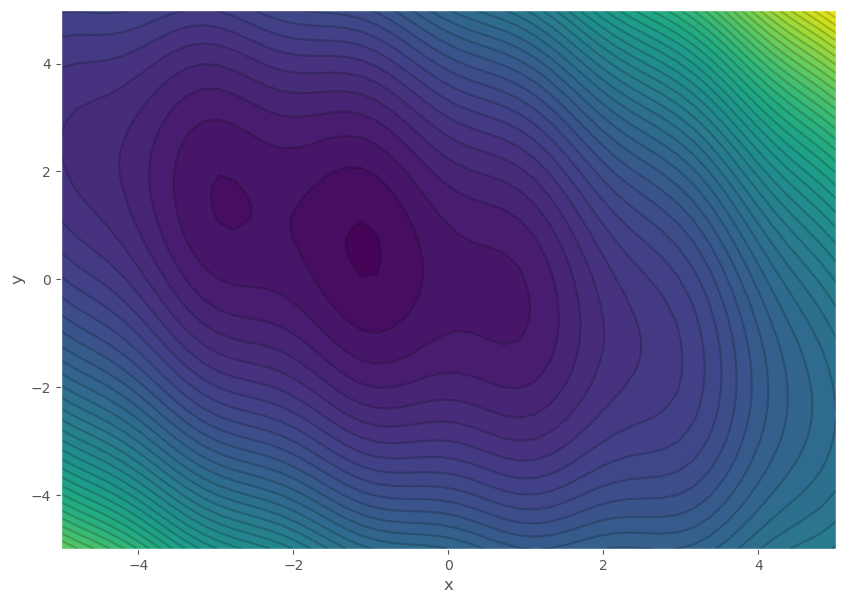

In [4]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**(a) Implement the gradient descent updates for $x$ and $y$ in the function below:<span style="float:right"> (1 point)</span>**

In [5]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - step_size*dx # TODO: compute the update
        y = y - step_size*dy # TODO: compute the update

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

In [6]:
# The following assert statements check that your implementation behaves sensibly
# Use it to get a hint only if you are stuck.
assert optimize_f(3, 2, 0.1, 1)[0] != 3, "Hint: you are not changing `x`"
assert optimize_f(3, 2, 0.1, 1)[2] < f(3, 2), "Hint: the function value is increasing, you should be minimizing it, not maximizing."
assert abs(optimize_f(3, 2, 0.1, 1)[0] - 3) < 1, "Hint: you are probably taking steps that are too large."

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [7]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')
    
    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**(b) Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

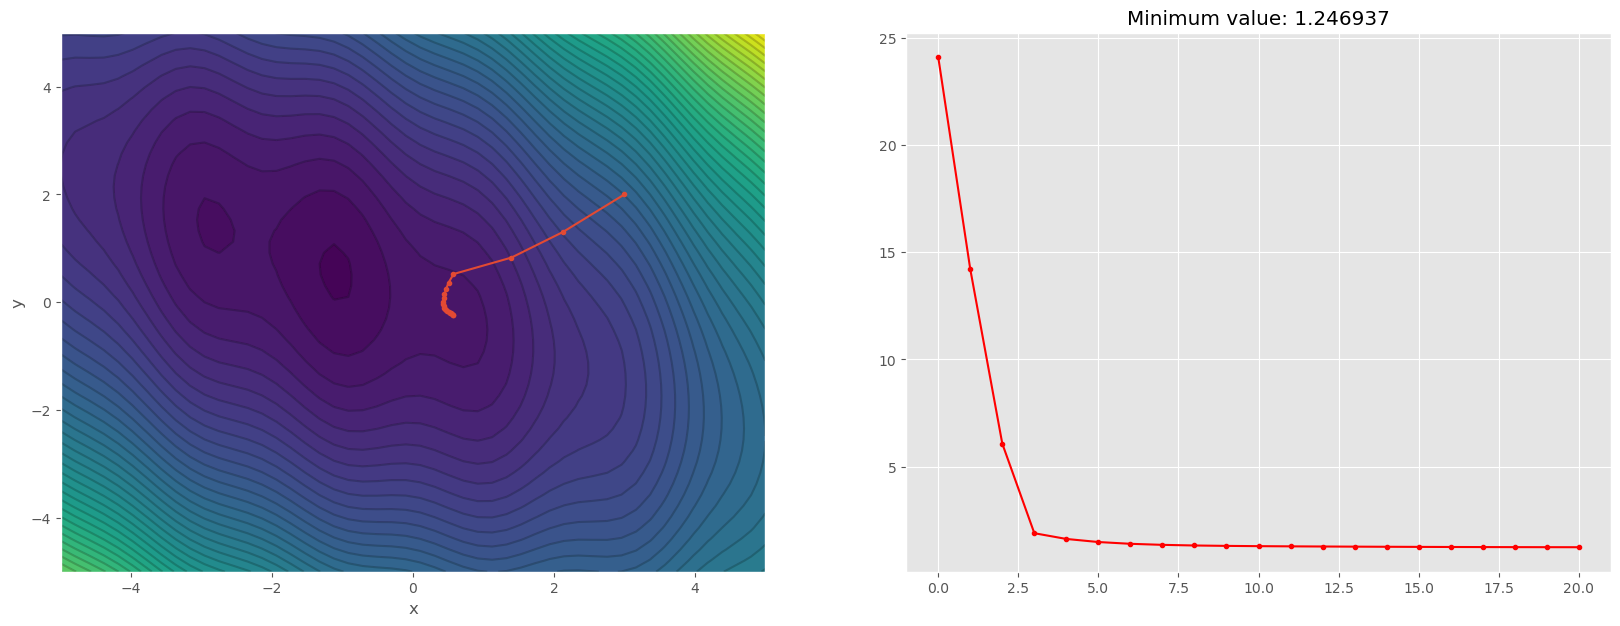

In [8]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=20)
plot_gradient_descent_results(*results)

**(c) Does it find the minimum of the function? What happens?<span style="float:right"> (1 point)</span>**

The algorithm got stuck in the local minimum.

**(d) Try a few different values for the `step_size` and the number of `steps` to get close to the optimal solution:**

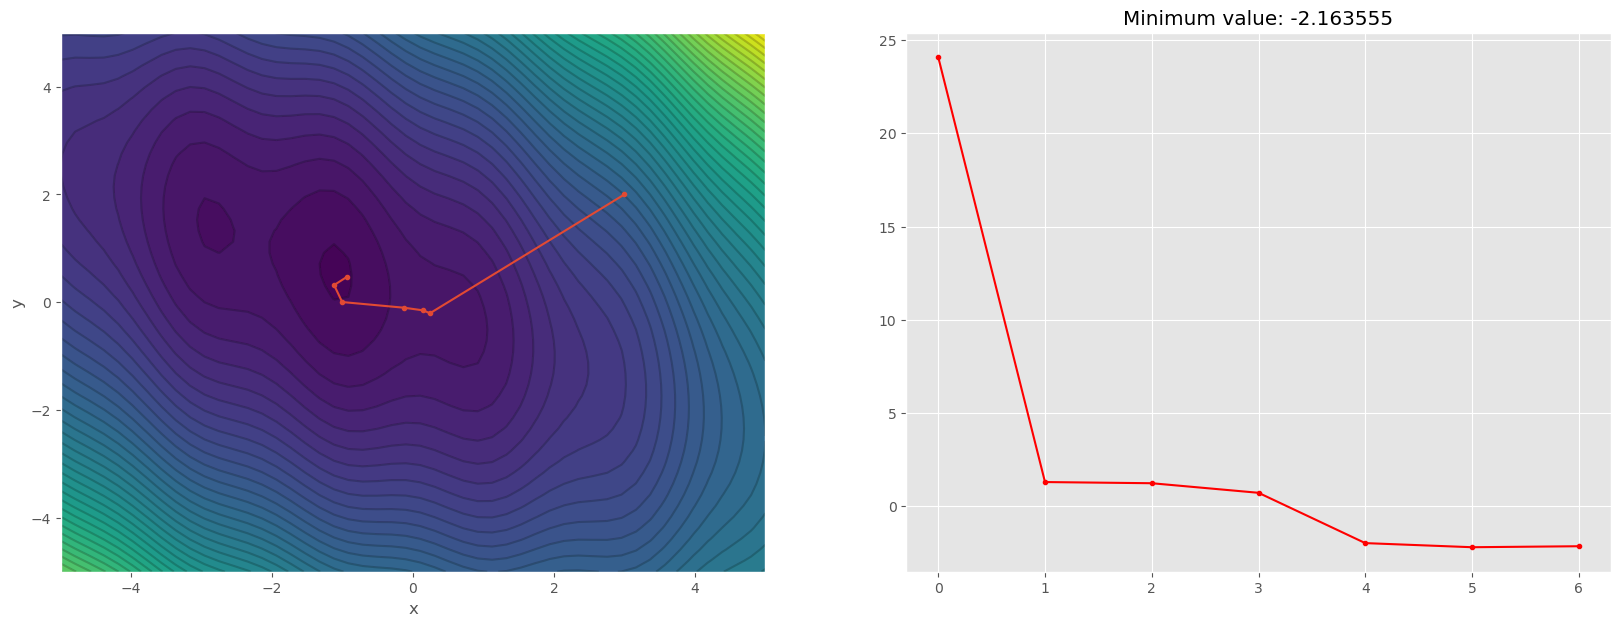

In [9]:
# TODO: tune the parameters to find a better optimum
results = optimize_f(x=3, y=2, step_size=0.315, steps=6)
plot_gradient_descent_results(*results)

**(e) What happens if you set the step size too small? And what if it is too large?<span style="float:right"> (1 point)</span>**

If the step_size is too small the algorithm will most likely get stuck in a local minimum (given large steps, otherwise it will slowly go in the direction if $-\nabla f(x,y)$) because the new point is too close to the previous (e.g. step_size=0.1, size=10 in the previous example). \
If the step_size is too large the algorithm will "shoot off" to a point that could be higher and then oscilate around the minimum, local or global (e.g. $f(x)=x^2$ and $\eta=1$ for x=1)

**(f) Were you able to find a step size that reached the global optimum? If not, why not?<span style="float:right"> (1 point)</span>**

step_size=0.315 and steps=6 got pretty close to the global optima but not exactly. There is no guarrantee that with a fixed step_size we could reach the global (or local) optimum exactly. If we are in the vicinity of a global optimum (point $x$) the algorithm will reach the minimum if we set the new step_size as: $\eta = \arg \min_{\eta} (x - \eta \nabla f(x))$ but this is generally hard or impossible to do.

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**(g) Update your optimization function to use this step size schedule:<span style="float:right"> (1 point)</span>**

In [10]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        eta=step_size * np.power(decay, step)
        # apply the gradient descent updates to x and y
        x = x  - eta*dx# TODO: compute the update including step size decay
        y = y  - eta*dy# TODO: compute the update including step size decay

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

In [11]:
# The following assert statement checks that your implementation behaves sensibly
_trace = optimize_f(0.123, 0.456, 0.01, 2, 0.1)[3]
assert abs(_trace[1] - _trace[0]) > 5 * abs(_trace[2] - _trace[1]), "Hint: step size should be decreasing"
del _trace

**(h) Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:<span style="float:right"> (1 point)</span>**

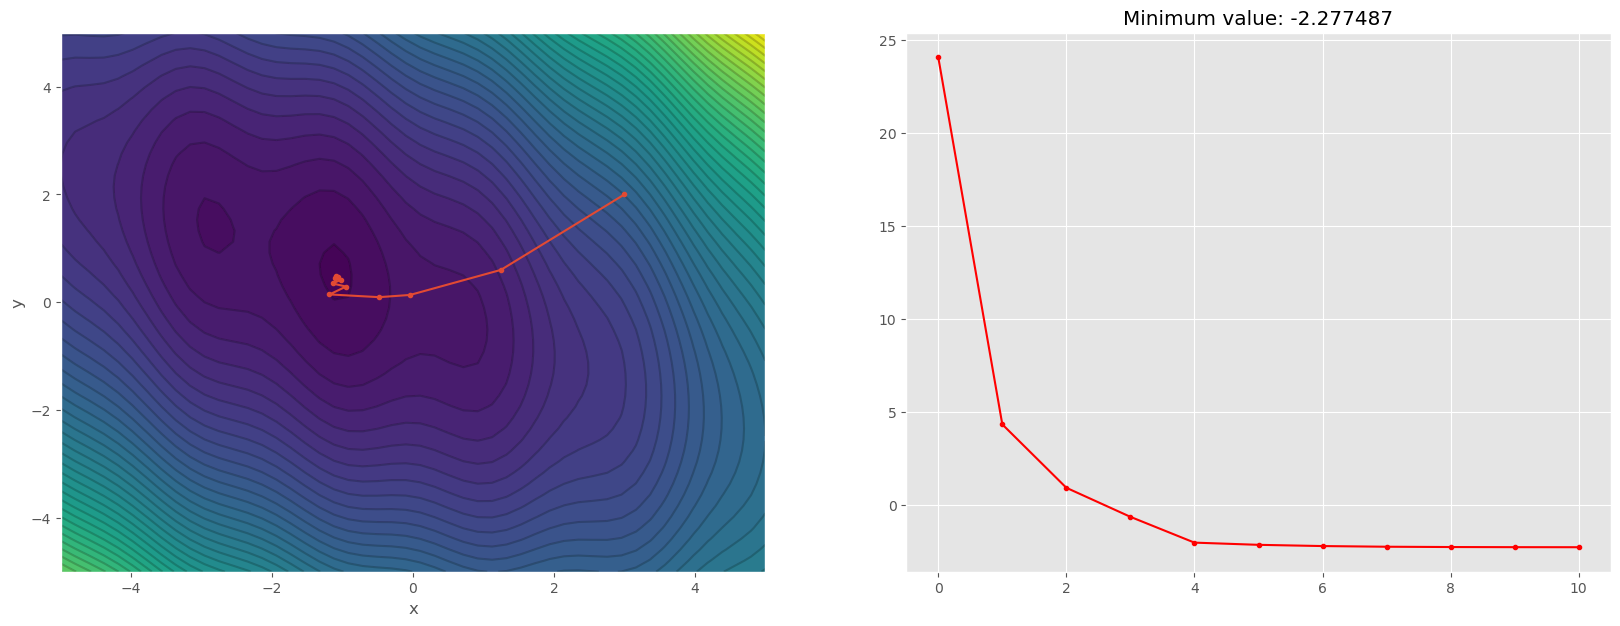

In [12]:
# TODO: tune the parameters to find the global optimum
results = optimize_f(x=3, y=2, step_size=0.2, steps=10, decay=0.95)
plot_gradient_descent_results(*results)

In [13]:
assert results[2] < -2, "Hint: get closer to the optimum"

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components (16 points)

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}

![Sigmoid](attachment:sigmoid.png)

**(a) Give the derivative of the sigmoid function:<span style="float:right"> (1 point)</span>**

\begin{align}
\frac{\partial \sigma(x)}{\partial x} &= \frac{e^{-x}}{(1 + e^{-x})^2} \\
\end{align}

**(b) Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:<span style="float:right"> (2 points)</span>**

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

# try with a random input
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [-5.45328  -3.664833  5.947309  3.525093 -2.177809]
sigmoid(x): [0.004264 0.024969 0.997394 0.971393 0.101761]
sigmoid_grad(x): [0.004246 0.024346 0.002599 0.027788 0.091406]


To check that the gradient implementation is correct, we can compute the numerical derivative using the [finite difference](https://en.wikipedia.org/wiki/Finite_difference) method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**(c) Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:<span style="float:right"> (1 point)</span>**

In [15]:
# start with some random inputs
rng = np.random.default_rng(12345)
x = rng.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic ', sigmoid_grad(x))

# TODO: compute the numerical gradient

h = 0.001
sigmoid_grad_cdm = (sigmoid(x + h/2) - sigmoid(x - h/2)) / h
print('Numerical', sigmoid_grad_cdm)

Symbolic  [0.188245 0.219215 0.178901 0.221338 0.238508]
Numerical [0.188245 0.219215 0.178901 0.221338 0.238508]


**(d) Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?<span style="float:right"> (1 point)</span>**

With the finite differences we get the same result up to a certain precision. This is because the finite differences are an approximation of the derivative.

**If there is a big difference between the two gradients, please try to make this as small as possible before you continue.**

### Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

![relu.png](attachment:relu.png)

**(e) Give the derivative of the ReLU function:<span style="float:right"> (1 point)</span>**

Note: this gradient is not well-defined everywhere, but make a sensible choice for all values of $x$.

\begin{align}
  \frac{\partial f(x)}{\partial x} &= \text{if } x < 0: 0 \text{ else } 1 \\
\end{align}

**(f) Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite difference method to check that the gradient is correct:<span style="float:right"> (2 points)</span>**

In [16]:
def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    return np.where(x < 0, 0, 1)

# try with a random input
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))


h = 0.001
relu_grad_cdm = (relu(x + h/2) - relu(x - h/2)) / h
print('Numerical relu_grad(x):', relu_grad_cdm)

x: [-5.45328  -3.664833  5.947309  3.525093 -2.177809]
relu(x): [0.       0.       5.947309 3.525093 0.      ]
relu_grad(x): [0 0 1 1 0]
Numerical relu_grad(x): [0. 0. 1. 1. 0.]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**(g) Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

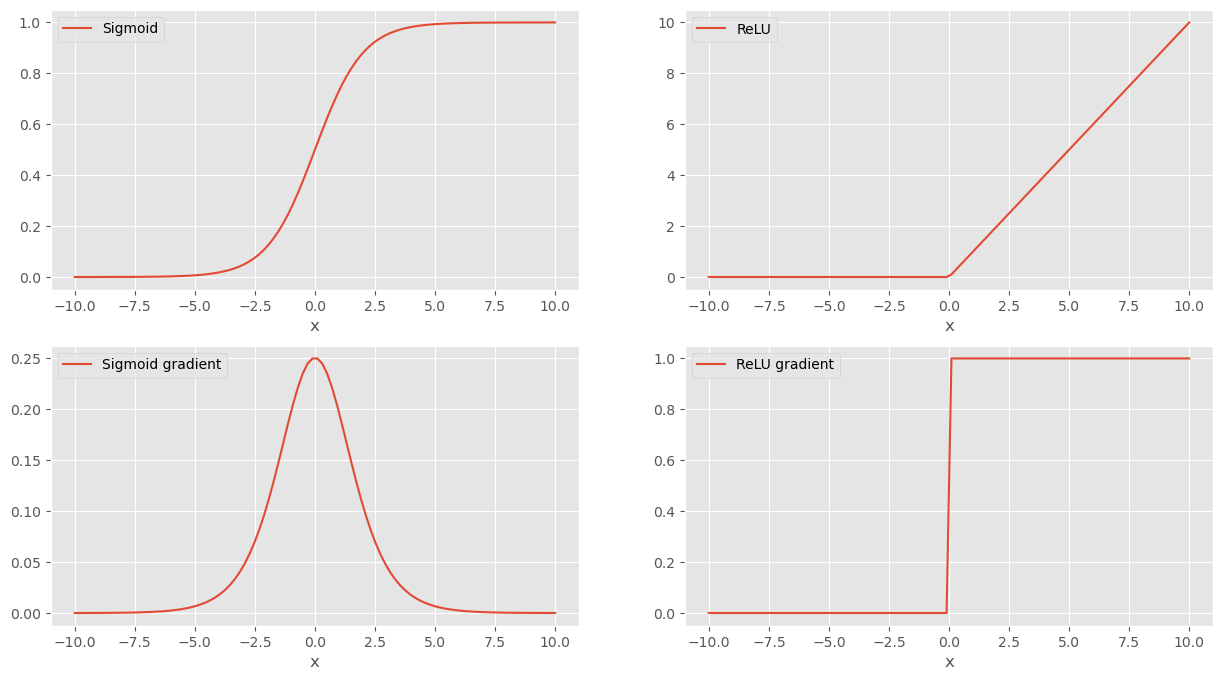

In [17]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**(h) Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in [0, 1]$? Why?<span style="float:right"> (1 point)</span>**

We would recommend the sigmoid function for probabilities, because it is bounded between 0 and 1.

**(i) Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function in terms of their gradient?<span style="float:right"> (1 point)</span>**

The ReLu gradient is either 0 or 1, which makes it easier to compute. The sigmoid gradient is more complex.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in [0, 1]$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**(j) Derive the gradient for the BCE loss:<span style="float:right"> (1 point)</span>**

\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= -(\frac{y}{\hat{y}}-\frac{1-y}{1-\hat{y}})
\end{align}

**(k) Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite difference method to check that the gradient is correct:<span style="float:right"> (3 points)</span>**

In [18]:
def bce_loss(y, y_hat):
    # TODO: implement the BCE loss
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
    raise NotImplementedError

def bce_loss_grad(y, y_hat):
    # TODO: implement the gradient of the BCE loss
    return -(y/y_hat - (1-y)/(1-y_hat))
    raise NotImplementedError

# try with some random inputs
rng = np.random.default_rng(12345)
y = rng.integers(2, size=5)
y_hat = rng.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print()

def bce_loss_grad_numerical(y, y_hat):
    h=0.001
    return (bce_loss(y,y_hat+h) - bce_loss(y,y_hat-h))/(2*h)

print("bce_loss_grad", bce_loss_grad(y,y_hat))
print("bce_loss_grad_numerical", bce_loss_grad_numerical(y,y_hat))
print("difference:", np.abs(bce_loss_grad(y,y_hat) - bce_loss_grad_numerical(y,y_hat)))
# TODO: compute and compare the symbolic and numerical gradient

y: [1 0 1 0 0]
y_hat: [0.676255 0.39111  0.332814 0.598309 0.186734]
bceloss(y, y_hat): [0.391186 0.496117 1.100172 0.912072 0.206697]

bce_loss_grad [-1.478733  1.642332 -3.004682  2.489474  1.22961 ]
bce_loss_grad_numerical [-1.478734  1.642333 -3.004691  2.489479  1.229611]
difference: [0.000001 0.000001 0.000009 0.000005 0.000001]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**(l) Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

_Hint: If you have trouble computing this in matrix notation directly, try to do the computation with scalars, writing the linear model as_
\begin{align}
  y_j = \sum_{i=1}^{N} x_i W_{ij} + b_j
\end{align}
where $j$ ranges from $1$ to $M$.

TODO: Your answer here.

\begin{align}
  \frac{\partial y_j}{\partial x_i} &= W_{ij} &
  \frac{\partial y_j}{\partial W_{ik}} &= TODO &
  \frac{\partial y_j}{\partial b_k} &= TODO \\
\end{align}
or
\begin{align}
  \frac{\partial \mathbf{y}}{\partial \mathbf{x}} &= TODO &
  \frac{\partial \mathbf{y}}{\partial \mathbf{W}} &= TODO &
  \frac{\partial \mathbf{y}}{\partial \mathbf{b}} &= TODO \\
\end{align}
(keep only one)

**(m) Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \\
  \nabla_\mathbf{W} \mathcal{L} &= \\
  \nabla_\mathbf{b} \mathcal{L} &= \\
\end{align}

## 1.3 Implement a one-layer model (2 points)

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x} \mathbf{w}^T + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get $\nabla_\mathbf{x} \mathcal{L}$, the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$.

Hint: in numpy inner product and matrix multiplication is denoted as `np.dot(A, B)` or as `A @ B`.

**(a) Complete the implementation below:<span style="float:right"> (2 points)</span>**

In [19]:
# initialize parameters
rng = np.random.default_rng(12345)
w = rng.normal(size=5)
b = rng.normal()

# implement the model
def fn(x, y):
    # TODO: forward: compute h, y_hat, loss
    h = 0
    y_hat = 0
    loss = 0
    
    # TODO: backward: compute grad_y_hat, grad_h, grad_x
    grad_y_hat = 0
    grad_h = 0
    grad_x = 0
    
    return loss, grad_x

# test with a random input
x = rng.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

assert np.isscalar(loss), "Loss should be scalar"
assert grad_x.shape == x.shape, "Gradient should have same shape as x"

Loss 0
Gradient 0


AttributeError: 'int' object has no attribute 'shape'

**(b) Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [ ]:
# start with some random inputs
rng = np.random.default_rng(12345)
x = rng.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a - loss_b) / eps

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)
    
print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions (5 points)

We will now construct a simple neural network. We need to implement the following objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the parameters of the layer, based on the gradient computed and stored by `backward`.

**(a) Implement a class `Linear` that computes `y = x*W + b`:<span style="float:right"> (3 points)</span>**

In [92]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out, rng = np.random.default_rng(12345)):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = rng.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        y = x @ self.W + self.b
        return y

    def backward(self, x, dy):
        # given dy, compute the gradients for x, W and b
        dx = dy @ self.W.T

        self.dW = x.T @ dy
        self.db = np.sum(dy, axis=0, keepdims=True)
        return dx
    
    def step(self, step_size):
        self.W -= step_size * self.dW
        self.b -= step_size * self.db

    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each dimension,
#  so you'll get an error if you mix them up.
rng = np.random.default_rng(12345)
x = rng.uniform(size=(3, 5))

layer = Linear(5, 7, rng=rng)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

# Verify correctness
assert y.shape == (3,7)
assert dx.shape == x.shape
layer.W *= 2
layer.b = layer.b * 2 + 1
y2 = layer.forward(x)
dx2 = layer.backward(x, np.ones_like(y))
assert np.all(y2 == 2 * y + 1)
assert np.all(dx2 == 2 * dx)

y: [[ 0.252427  0.428688 -0.081518  0.207314 -0.058535 -0.005779  0.059303]
 [ 0.382911  0.146397 -0.275544 -0.026378 -0.333927 -0.537221 -0.223564]
 [ 0.15955   0.155119 -0.222059  0.428698 -0.231045 -0.345936 -0.119919]]
dx: [[-0.326296 -0.992105  1.657474  0.165888 -0.622481]
 [-0.326296 -0.992105  1.657474  0.165888 -0.622481]
 [-0.326296 -0.992105  1.657474  0.165888 -0.622481]]


**(b) Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:<span style="float:right"> (1 point)</span>**

In [30]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        return sigmoid(x)

    def backward(self, x, dy):
        # TODO: compute the backward pass,
        # return the gradient for x given the gradient for y

        dx = sigmoid_grad(x) * dy
        self.dW = x.T @ dx
        self.db = dy
        return dx

    def step(self, step_size):
        self.W -= step_size * self.dW
        self.b -= step_size * self.db

    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
rng = np.random.default_rng(12345)
x = rng.normal(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

assert y.shape == x.shape, "Output sigmoid should have the same shape as input"
assert dx.shape == x.shape, "Gradient sigmoid should have the same shape as input"
assert np.all(y > 0) and np.all(y < 1), "Output of sigmoid should be between 0 and 1"

y: [[0.194063 0.779667 0.295117 0.435567 0.481173]
 [0.322811 0.202977 0.656761 0.589297 0.124242]
 [0.912728 0.72482  0.318779 0.711401 0.385338]]
dx: [[0.156402 0.171786 0.208023 0.245848 0.249646]
 [0.218604 0.161777 0.225426 0.242026 0.108806]
 [0.079656 0.199456 0.217159 0.20531  0.236853]]


In [ ]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

rng = np.random.default_rng(12345)
err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of Sigmoid.backward."

**(c) Implement a class `ReLU` that computes `y = max(0, x)`:<span style="float:right"> (1 point)</span>**

In [ ]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        # TODO: compute the forward pass
        raise NotImplementedError  # TODO

    def backward(self, x, dy):
        # TODO: compute the backward pass,
        # return the gradient for x given dy
        raise NotImplementedError  # TODO

    def step(self, step_size):
        raise NotImplementedError  # TODO

    def __str__(self):
        return 'ReLU'


# try the new class with some random values
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

assert y.shape == x.shape, "Output of ReLU should have the same shape as input"
assert dx.shape == x.shape, "Gradient of ReLU should have the same shape as input"

### Verify the gradients

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**(d) Run the code and check that the error is not too large.**

In [97]:
## Verify gradient computations for Linear
# test for dx
rng = np.random.default_rng(12345)
layer = Linear(5, 7, rng)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=3 * 5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of Linear.backward."

# test for dW
x = rng.uniform(size=(3, 5))
layer = Linear(5, 7, rng)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=5 * 7))
print("err on dW:", err)
assert np.abs(err) < 1e-5, "Error on dW is too large, check your implementation of Linear.backward."

# test for db
x = rng.uniform(size=(3, 5,))
layer = Linear(5, 7, rng)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db

err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=7))
print("err on db:", err)
assert np.abs(err) < 1e-5, "Error on db is too large, check your implementation of Linear.backward."

err on dx: 8.877935601100038e-07
err on dW: 1.671517959170096e-06
err on db: 0.0


In [ ]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

rng = np.random.default_rng(12345)
err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(1, 10, size=5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of ReLU.backward."

## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**(a) Read the code below:**

In [ ]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network (10 points)

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

In [ ]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [ ]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
rng = np.random.default_rng(12345)
idxs = rng.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**(a) Read through the code below.**

In [ ]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**(b) Train the network and inspect the results. Tune the hyperparameters to get a good result.<span style="float:right"> (1 point)</span>**

In [ ]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
        Linear(64, 32, rng=rng),
        ReLU(),
        Linear(32, 1, rng=rng),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net, x, y,
    epochs = 25,
    learning_rate = 0,
    mb_size = 10)

# Note: add more cells below if you want to keep runs with different hyperparameters. Make sure to also copy the network construction.

**(c) How did each of the hyperparameters (number of epochs, learning rate, minibatch size) influence your results? How important is it to set each correctly?<span style="float:right"> (3 points)</span>**

TODO: Your answer here.

**(d) Create and train a network with one linear layer followed by a sigmoid activation:<span style="float:right"> (1 point)</span>**

`net = Net([Linear(...), Sigmoid()]`

In [ ]:
# TODO: Your code here.

**(e) Discuss your results. Compare the results of this single-layer network with those of the network you trained before.<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(f) Repeat the experiment with a network with two linear layers, followed by a sigmoid activation: `[Linear, Linear, Sigmoid]`.<span style="float:right"> (1 point)</span>**

In [ ]:
# TODO: Your code here.

**(g) How does the performance of this network compare with the previous networks. Can you explain this result? What is the influence of the activation functions in the network?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(h) One way to improve the performance of a neural network is by increasing the number of layers. Try a deeper network (e.g., a network with four linear layers) to see if this outperforms the previous networks.<span style="float:right"> (1 point)</span>**

In [ ]:
# TODO: Your code here.

**(i) Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## 1.7 Final questions (6 points)

You now have some experience training neural networks. Time for a few final questions.

**(a) What is the influence of the learning rate? What happens if the learning rate is too low or too high?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(b) What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(c) In the linear layer, we initialized the weights $w$ with random values, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 45 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 00f98aa / 2023-09-04</span>